In [1]:
import numpy as np
import pandas as pd
import os,pathlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

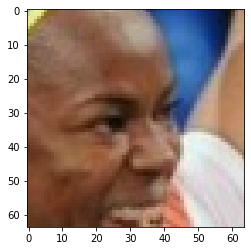

In [3]:
path='/content/drive/MyDrive/celeba'+'/161979.jpg'
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
print(img.shape)
print(type(img))

(64, 64, 3)
<class 'numpy.ndarray'>


##Creating our dataset

In [5]:
#24396 images in the celeba dataset

In [6]:
path_d='/content/drive/MyDrive/celeba'
ct=161979
X = np.zeros((1000,64 , 64, 3), dtype=np.float32)
for path in pathlib.Path(path_d).iterdir():
  img = cv2.imread(str(path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype('float32')
  X[ct-161979]=img/255
  if (ct-161979)==999:
    break
  ct+=1

##Encoder

In [7]:
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(4608)(x)
encoded = layers.Reshape((3,3,512))(x)
encoder = keras.Model(input_img, encoded,name="encoder")

##Decoder

In [8]:
decoder_input= layers.Input(shape=((3,3,512)))
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((64, 64, 3)))(x)
decoded = layers.Reshape((64, 64, 3))(x)
decoder = keras.Model(decoder_input, decoded,name="decoder")

In [11]:
auto_input = layers.Input(shape=(64,64,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 3, 3, 512)         6470400   
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 3)         16954240  
Total params: 23,424,640
Trainable params: 23,424,640
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,X, test_size=0.20, random_state=0)

In [13]:
checkpoint1 = ModelCheckpoint("autoencoder_celeba.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=64, shuffle=True, validation_data=(X_test, X_test), callbacks=[checkpoint1])

Epoch 1/1000
13/13 [==============================] - 19s 85ms/step - loss: 0.4547 - val_loss: 0.4309

Epoch 00001: val_loss improved from inf to 0.43086, saving model to autoencoder_celeba.hdf5
Epoch 2/1000
13/13 [==============================] - 1s 40ms/step - loss: 0.3267 - val_loss: 0.2081

Epoch 00002: val_loss improved from 0.43086 to 0.20806, saving model to autoencoder_celeba.hdf5
Epoch 3/1000
13/13 [==============================] - 1s 40ms/step - loss: 0.1763 - val_loss: 0.1603

Epoch 00003: val_loss improved from 0.20806 to 0.16031, saving model to autoencoder_celeba.hdf5
Epoch 4/1000
13/13 [==============================] - 1s 40ms/step - loss: 0.1599 - val_loss: 0.1569

Epoch 00004: val_loss improved from 0.16031 to 0.15687, saving model to autoencoder_celeba.hdf5
Epoch 5/1000
13/13 [==============================] - 1s 40ms/step - loss: 0.1554 - val_loss: 0.1672

Epoch 00005: val_loss did not improve from 0.15687
Epoch 6/1000
13/13 [==============================] - 1s 4

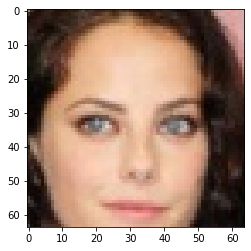

In [22]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[100])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


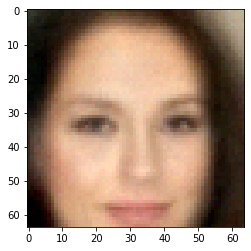

In [23]:
output_image = autoencoder.predict(np.array([X_test[100]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()